# Benchmark Dataset

## Torch Geometric Dataset 구성
#### data.x: 
- 노드 특징 행렬
- [num_nodes, num_node_features

#### data.edge_index: 
- 그래프의 연결성
- [2, num_edges]
#### data.edge_attr:
- 엣지 특징 행렬
- [num_edges, num_edge_features]
#### data.y: 
- 학습하고 싶은 대상 (타겟)
- 그래프 레벨 → [num_nodes, *]
- 노드 레벨 → [1, *]
#### data.pos:
- 노드 위치 행렬
- [num_nodes, num_dimensions]

### Torch Graph-set 만들기

In [97]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor(
    [[0, 1, 1, 2],
     [1, 0, 2, 1]], dtype=torch.long
)

x = torch.tensor(
    [[-1], 
     [0], 
     [1]], dtype=torch.float
)

data = Data(x=x, edge_index=edge_index)

In [98]:
data

Data(x=[3, 1], edge_index=[2, 4])

In [99]:
data.x

tensor([[-1.],
        [ 0.],
        [ 1.]])

In [100]:
data.edge_index

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

### 연속적인 Graph-set

In [65]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor(
    [[0, 1],
     [1, 0],
     [1, 2]], dtype=torch.long
)
x = torch.tensor(
    [[-1], 
     [0], 
     [1]], dtype=torch.float
)

data = Data(x=x, edge_index=edge_index.t().contiguous())

In [66]:
data

Data(x=[3, 1], edge_index=[2, 3])

In [67]:
data.x

tensor([[-1.],
        [ 0.],
        [ 1.]])

In [68]:
data.edge_index

tensor([[0, 1, 1],
        [1, 0, 2]])

### Graph Visualization

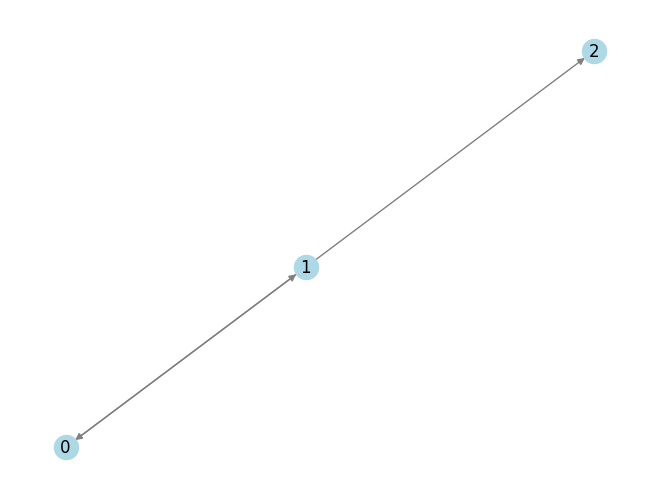

In [73]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=False)

# 그래프 그리기
nx.draw(
    G, with_labels=True, 
    node_color='lightblue', 
    edge_color='gray', 
    arrowstyle='-|>', 
    arrowsize=10
)
plt.show()

### torch_geometric.data.Data
- `data.keys` : 해당 속성 이름
- `data.num_nodes` : 노드 총 개수
- `data.num_edges` : 엣지 총 개수
- `data.contains_isolated_nodes()` : 고립 노드 여부 확인
- `data.contains_self_loops()` : 셀프 루프 포함 여부 확인
- `data.is_directed() : 그래프의 방향성 여부 확인

## Cora Dataset

In [101]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='dataset', name='Cora')

In [102]:
dataset.num_classes

7

In [103]:
dataset.num_node_features

1433

In [104]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [105]:
data.is_undirected()

True

In [106]:
data.train_mask.sum().item()

140

In [107]:
data.val_mask.sum().item()

500

In [108]:
data.test_mask.sum()

tensor(1000)

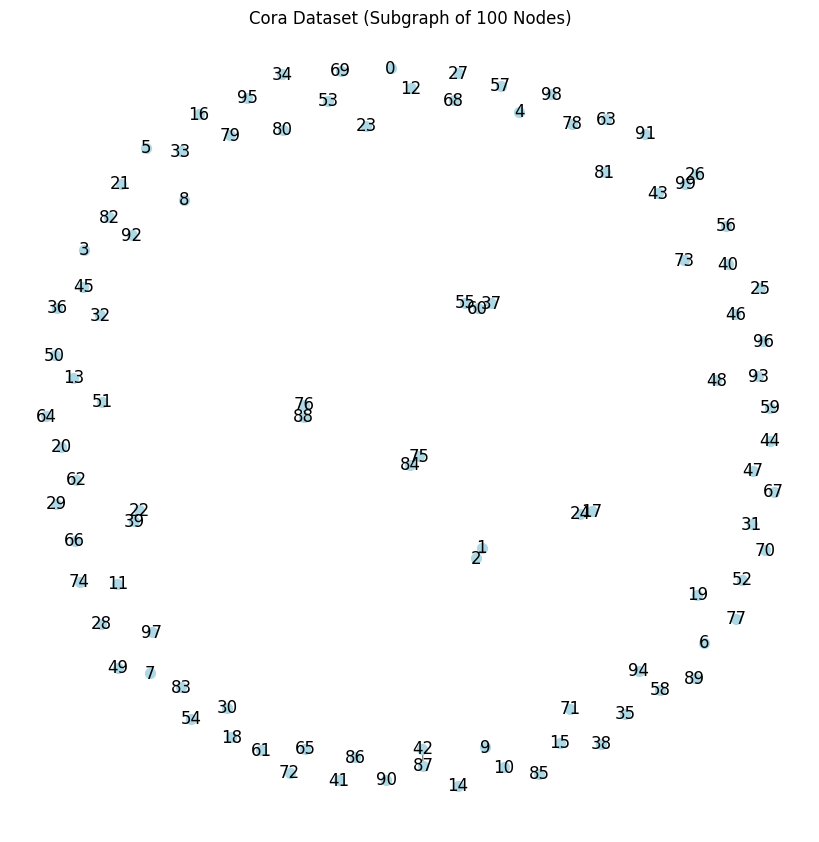

In [109]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Cora 데이터셋의 첫 번째 그래프 데이터 로드
data = dataset[0]

# 전체 그래프를 NetworkX로 변환 (방향성 없음)
G = to_networkx(data, to_undirected=True)

# 서브 그래프 추출 (예: 첫 100개 노드만 선택)
subgraph_nodes = list(G.nodes)[:100]
subgraph = G.subgraph(subgraph_nodes)

# 그래프 시각화
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subgraph, seed=42)  # 레이아웃 설정
nx.draw(
    subgraph, 
    pos, 
    node_size=50, 
    with_labels=True, 
    edge_color='gray', 
    node_color='lightblue'
)
plt.title("Cora Dataset (Subgraph of 100 Nodes)")
plt.show()

## Data Transform

In [110]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit, AddSelfLoops
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

### Data Load

In [92]:
# 1. 데이터셋 로드 및 탐색
dataset = Planetoid(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

print("**Cora Dataset 탐색:")
print(f"Number of nodes: {data.num_nodes}")  # 노드 수
print(f"Number of edges: {data.num_edges}")  # 엣지 수
print(f"Number of features: {data.num_features}")  # 노드 피처 수
print(f"Number of classes: {data.y.max().item() + 1}")  # 클래스 수
print("**Graph 탐색:")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")  # 고립된 노드 여부
print(f"Has self-loops: {data.has_self_loops()}")  # 자기 루프 여부
print(f"Is undirected: {data.is_undirected()}")  # 무방향 그래프 여부

**Cora Dataset 탐색:
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
**Graph 탐색:
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Train/Valid/Test Transform

In [93]:
# 2. Train/Valid/Test 분할

from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit, AddSelfLoops

# RandomLinkSplit을 사용해 링크 예측을 위한 분할 (노드 분할은 Planetoid에 이미 포함됨)
transform = RandomLinkSplit(
    num_val=0.1,  # 검증 세트 비율
    num_test=0.2,  # 테스트 세트 비율
    is_undirected=True,  # 무방향 그래프로 처리
    add_negative_train_samples=False  # 학습 시 negative 샘플 추가 여부
)
train_data, val_data, test_data = transform(data)

print("\nTrain/Valid/Test 분할 결과:")
print(f"Train edges: {train_data.edge_index.shape[1]}")  # 학습용 엣지 수
print(f"Validation edges: {val_data.edge_index.shape[1]}")  # 검증용 엣지 수
print(f"Test edges: {test_data.edge_index.shape[1]}")  # 테스트용 엣지 수


Train/Valid/Test 분할 결과:
Train edges: 7392
Validation edges: 7392
Test edges: 8446


### Augmenation

In [94]:
# 3. Augmentation (예: 자기 루프 추가)
augmented_data = AddSelfLoops()(data)
print("\nAugmentation 결과 (자기 루프 추가):")
print(f"Augmented edges: {augmented_data.edge_index.shape[1]}")


Augmentation 결과 (자기 루프 추가):
Augmented edges: 13264


### Visualization

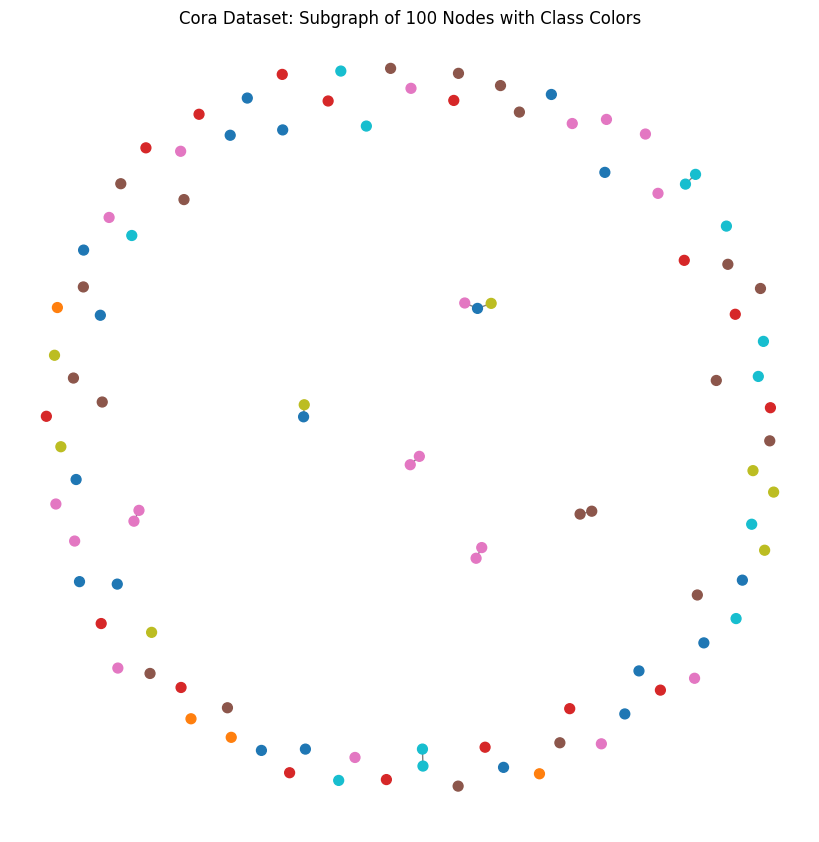

In [112]:
# 5. 시각화 (서브 그래프로 탐색)
# 첫 100개 노드로 서브 그래프 생성
G = to_networkx(data, to_undirected=True)
subgraph_nodes = list(G.nodes)[:100]
subgraph = G.subgraph(subgraph_nodes)

# 클래스에 따라 노드 색상 지정
node_colors = data.y.numpy()[:100]

# 그래프 시각화
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(
    subgraph, 
    pos, 
    node_size=50, 
    with_labels=False, 
    edge_color='gray', 
    node_color=node_colors, 
    cmap=plt.cm.tab10
)
plt.title("Cora Dataset: Subgraph of 100 Nodes with Class Colors")
plt.show()